## Importing libraries

In [2]:
import pandas as pd # to store data efficiently
import numpy as np # to handle numerical operations
import random # to generate random numbers
import os # to handle operations regarding file system
import wget # to download locally images
from ultralytics import YOLO # to import YOLO model
from tqdm import tqdm # to visualize loop progressions
import matplotlib.pyplot as plt


## Getting images list with people from COCO dataset

In [4]:
anns_df = pd.read_csv('./data/coco_diff/single_anns/person_anns.csv')

In [5]:
df = pd.read_csv('./data/yolo_prediction/single_person_predictions.csv')

In [18]:
grouped_df = df.groupby('Img_ID')[['Confidence']].mean()

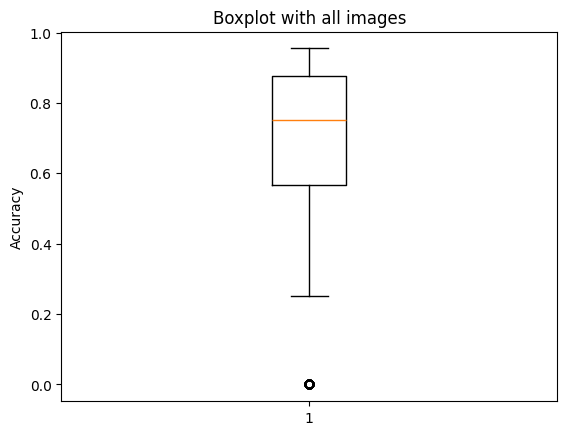

In [19]:
plt.boxplot(grouped_df)

plt.title("Boxplot with all images")
plt.ylabel("Accuracy")
plt.show()

In [30]:
df[(df['Confidence']==0)]

,Img_ID,Confidence,x_center,y_center,width,height
ID,,,,,,
1900,1900,0.0,NaN,NaN,NaN,NaN
2764,2764,0.0,NaN,NaN,NaN,NaN
6789,6789,0.0,NaN,NaN,NaN,NaN
8187,8187,0.0,NaN,NaN,NaN,NaN
12109,12109,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
548174,548174,0.0,NaN,NaN,NaN,NaN
550834,550834,0.0,NaN,NaN,NaN,NaN
563947,563947,0.0,NaN,NaN,NaN,NaN
